In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import astropy

import matplotlib.pyplot as plt
%matplotlib inline

2023-04-12 12:44:08.106812: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-04-12 12:44:08.106847: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
import seaborn as sns

## Simulation (train/validation set) examples

In [ ]:
blended_images = np.load('/sps/lsst/users/bbiswas/simulations/CATSIM_10_btk_shifted_blended_validation/batch1.npy', allow_pickle=True)

In [ ]:
linear_norm_coeff = [1000, 5000, 10000, 10000, 10000, 10000]

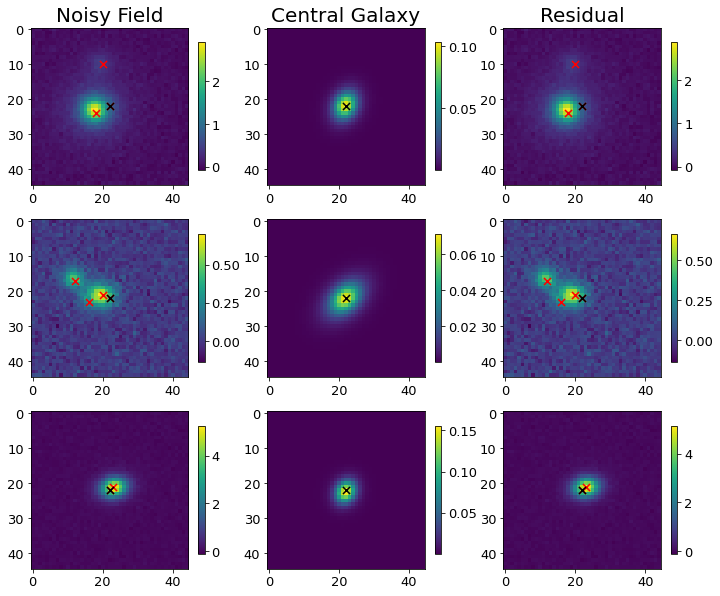

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

rng= np.random.default_rng(seed=5)

band = 2

for i in range(3):
    image_num = i + rng.integers(0, 100)
    im = axs[i, 0].imshow(blended_images['blended_gal_stamps'][image_num][:, :, band]/linear_norm_coeff[band])
    cbar = fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)

    im = axs[i, 1].imshow(blended_images['isolated_gal_stamps'][image_num][:, :, band]/linear_norm_coeff[band])
    cbar = fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)


    difference = blended_images['blended_gal_stamps'][image_num][:, :, band] - blended_images['isolated_gal_stamps'][image_num][:, :, band]
    im = axs[i, 2].imshow(difference/linear_norm_coeff[band])
    cbar = fig.colorbar(im, ax=axs[i, 2],shrink=0.8)
    cbar.ax.tick_params(labelsize=13)

    for num_gal in range(len(blended_images["gal_locations_x_peak"][image_num])):

        axs[i, 0].scatter(np.round(blended_images["gal_locations_x_peak"][image_num][num_gal]) + 22, 
                          np.round(blended_images["gal_locations_y_peak"][image_num][num_gal]) + 22, 
                          c="r", 
                          marker="x", 
                          s=50
                         )

        axs[i, 2].scatter(np.round(blended_images["gal_locations_x_peak"][image_num][num_gal]) + 22, 
                          np.round(blended_images["gal_locations_y_peak"][image_num][num_gal]) + 22, 
                          c="r", 
                          marker="x", 
                          s=50
                         )
    
    for col_num in range(3):
        axs[i, col_num].scatter(22, 22, c="black", marker="x", s=50)
        axs[i, col_num].tick_params(axis='both', which='major', labelsize=13)


axs[0, 0].set_title("Noisy Field", fontsize=20)
axs[0, 1].set_title("Central Galaxy", fontsize=20)
axs[0, 2].set_title("Residual", fontsize=20)
plt.savefig("results/blended_galaxies")
plt.savefig("results/blended_galaxies.pdf", bbox_inches = 'tight')

# Make plots for isolated galaxies

In [ ]:
isolated_images = np.load('/sps/lsst/users/bbiswas/simulations/CATSIM_10_btk_shifted_isolated_validation/batch1.npy', allow_pickle=True)

In [ ]:
linear_norm_coeff = [1000, 5000, 10000, 10000, 10000, 10000]

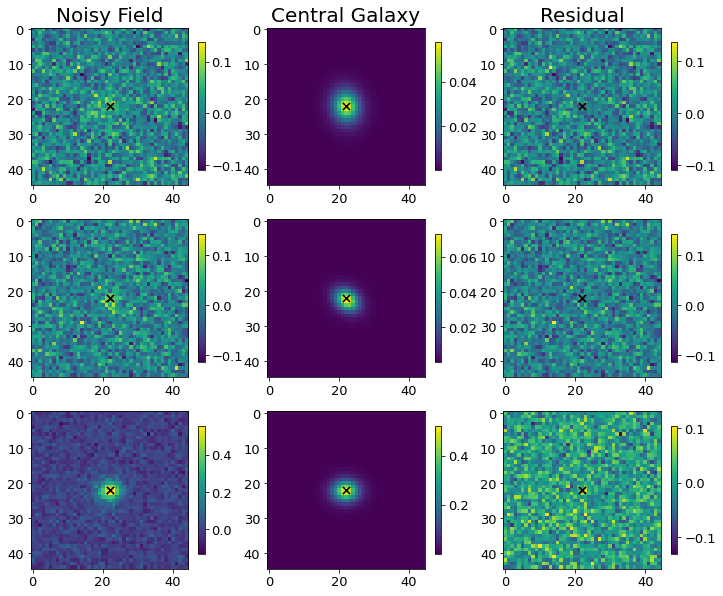

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

rng= np.random.default_rng(seed=5)

band = 2

for i in range(3):
    image_num = i + rng.integers(0, 100)
    im = axs[i, 0].imshow(isolated_images['blended_gal_stamps'][image_num][:, :, band]/linear_norm_coeff[band])
    cbar = fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)

    im = axs[i, 1].imshow(isolated_images['isolated_gal_stamps'][image_num][:, :, band]/linear_norm_coeff[band])
    cbar = fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)


    difference = isolated_images['blended_gal_stamps'][image_num][:, :, band] - isolated_images['isolated_gal_stamps'][image_num][:, :, band]
    im = axs[i, 2].imshow(difference/linear_norm_coeff[band])
    cbar = fig.colorbar(im, ax=axs[i, 2],shrink=0.8)
    cbar.ax.tick_params(labelsize=13)


    axs[i, 0].scatter(np.round(isolated_images["gal_locations_x_peak"][image_num]) + 22, 
                      np.round(isolated_images["gal_locations_y_peak"][image_num]) + 22, 
                      c="r", 
                      marker="x", 
                      s=50
                     )

    axs[i, 2].scatter(np.round(isolated_images["gal_locations_x_peak"][image_num]) + 22, 
                      np.round(isolated_images["gal_locations_y_peak"][image_num]) + 22, 
                      c="r", 
                      marker="x", 
                      s=50
                     )
    
    for col_num in range(3):
        axs[i, col_num].scatter(22, 22, c="black", marker="x", s=50)
        axs[i, col_num].tick_params(axis='both', which='major', labelsize=13)


axs[0, 0].set_title("Noisy Field", fontsize=20)
axs[0, 1].set_title("Central Galaxy", fontsize=20)
axs[0, 2].set_title("Residual", fontsize=20)
plt.savefig("results/isolated_galaxies")
plt.savefig("results/isolated_galaxies.pdf", bbox_inches = 'tight')

In [ ]:
from maddeb.FlowVAEnet import FlowVAEnet
from maddeb.utils import listdir_fullpath, get_data_dir_path

data_dir = get_data_dir_path()

tf.get_logger().setLevel('ERROR')
latent_dim = 16
flow_net = FlowVAEnet(latent_dim=latent_dim)
flow_net.load_flow_weights(weights_path=os.path.join(data_dir, f"catsim_kl01{latent_dim}d/flow8_tanh/val_loss"))
flow_net.load_vae_weights(weights_path=os.path.join(data_dir, f"catsim_kl01{latent_dim}d/deblender/val_loss"))
flow_net.vae_model.trainable=False
print(flow_net.vae_model.summary())

2023-04-12 12:44:57.868764: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-04-12 12:44:57.868807: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-12 12:44:57.868834: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2023-04-12 12:44:57.869037: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 12

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 45, 45, 6)]       0         
_________________________________________________________________
encoder (Functional)         (None, 152)               7030296   
_________________________________________________________________
latent_space (MultivariateNo ((None, 16), (None, 16))  0         
_________________________________________________________________
decoder (Functional)         (None, 45, 45, 6)         4966790   
Total params: 11,997,086
Trainable params: 0
Non-trainable params: 11,997,086
_________________________________________________________________
None


In [ ]:
np.shape(np.array(list(blended_images['blended_gal_stamps'])))

(100, 45, 45, 6)

In [ ]:
tf.get_logger().setLevel('ERROR')
model_vae_output_isolated = flow_net.vae_model(np.array(list(blended_images['blended_gal_stamps']))/linear_norm_coeff)
model_vae_output_isolated = model_vae_output_isolated

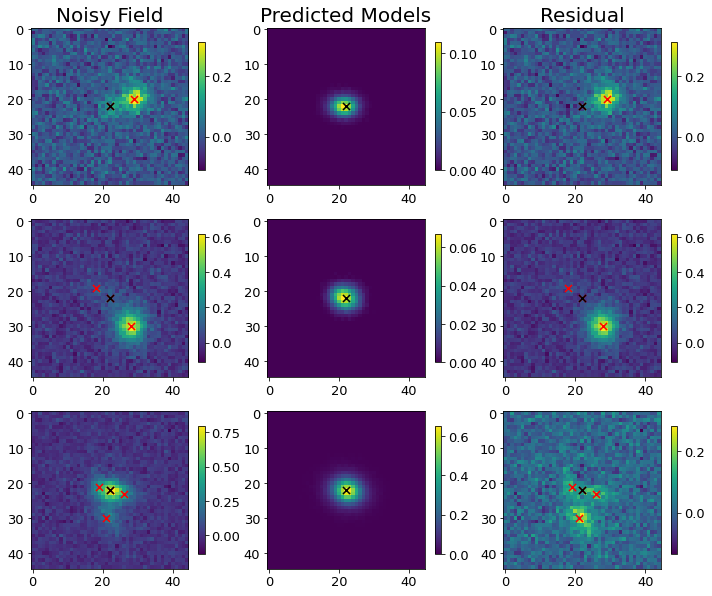

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

rng= np.random.default_rng(seed=7)

band = 2

for i in range(3):
    image_num = i + rng.integers(0, 100)
    im = axs[i, 0].imshow(blended_images['blended_gal_stamps'][image_num][:, :, band]/linear_norm_coeff[band])
    cbar = fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)

    im = axs[i, 1].imshow(model_vae_output_isolated[image_num][:, :, band])
    cbar = fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)


    difference = blended_images['blended_gal_stamps'][image_num][:, :, band]/linear_norm_coeff[band] -model_vae_output_isolated[image_num][:, :, band]
    im = axs[i, 2].imshow(difference)
    cbar = fig.colorbar(im, ax=axs[i, 2],shrink=0.8)
    cbar.ax.tick_params(labelsize=13)


    for num_gal in range(len(blended_images["gal_locations_x_peak"][image_num])):

        axs[i, 0].scatter(np.round(blended_images["gal_locations_x_peak"][image_num][num_gal]) + 22, 
                          np.round(blended_images["gal_locations_y_peak"][image_num][num_gal]) + 22, 
                          c="r", 
                          marker="x", 
                          s=50
                         )

        axs[i, 2].scatter(np.round(blended_images["gal_locations_x_peak"][image_num][num_gal]) + 22, 
                          np.round(blended_images["gal_locations_y_peak"][image_num][num_gal]) + 22, 
                          c="r", 
                          marker="x", 
                          s=50
                         )
    
    for col_num in range(3):
        axs[i, col_num].scatter(22, 22, c="black", marker="x", s=50)
        axs[i, col_num].tick_params(axis='both', which='major', labelsize=13)


axs[0, 0].set_title("Noisy Field", fontsize=20)
axs[0, 1].set_title("Predicted Models", fontsize=20)
axs[0, 2].set_title("Residual", fontsize=20)
plt.savefig("results/VAEDeblender")
plt.savefig("results/VAEDeblender.pdf", bbox_inches = 'tight')

# Blendedness variation

In [ ]:
data_path = "/sps/lsst/users/bbiswas/MADNESS_results/high_density"
run_name = "kl01" # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [ ]:
madness_results=[]
scarlet_results=[]
actual_photometry = []
blended_photometry = []

for file_num in range(100):

    madness_results.append(pd.read_pickle(os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")))
    #scarlet_results.append(pd.read_pickle(os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")))

    #actual_photometry.append(pd.read_pickle(os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")))
    #blended_photometry.append(pd.read_pickle(os.path.join(data_path, "blended_photometry",  str(file_num) + ".pkl")))

madness_results = pd.concat(madness_results)
#scarlet_results = pd.concat(scarlet_results)

#actual_photometry = pd.concat(actual_photometry)
#blended_photometry = pd.concat(blended_photometry)

In [ ]:
madness_results.columns

Index(['u_covariance', 'u_actual_flux', 'u_predicted_flux', 'u_blendedness',
       'g_covariance', 'g_actual_flux', 'g_predicted_flux', 'g_blendedness',
       'r_covariance', 'r_actual_flux', 'r_predicted_flux', 'r_blendedness',
       'i_covariance', 'i_actual_flux', 'i_predicted_flux', 'i_blendedness',
       'z_covariance', 'z_actual_flux', 'z_predicted_flux', 'z_blendedness',
       'y_covariance', 'y_actual_flux', 'y_predicted_flux', 'y_blendedness',
       'galaxy_num', 'size', 'field_num', 'file_num', 'r_band_snr', 'ref_mag',
       'u_phot_flux', 'u_phot_fluxerrs', 'u_phot_flags', 'g_phot_flux',
       'g_phot_fluxerrs', 'g_phot_flags', 'r_phot_flux', 'r_phot_fluxerrs',
       'r_phot_flags', 'i_phot_flux', 'i_phot_fluxerrs', 'i_phot_flags',
       'z_phot_flux', 'z_phot_fluxerrs', 'z_phot_flags', 'y_phot_flux',
       'y_phot_fluxerrs', 'y_phot_flags'],
      dtype='object')

In [ ]:
simulation_path = os.path.join("/sps/lsst/users/bbiswas/simulations/test_data/", "high")

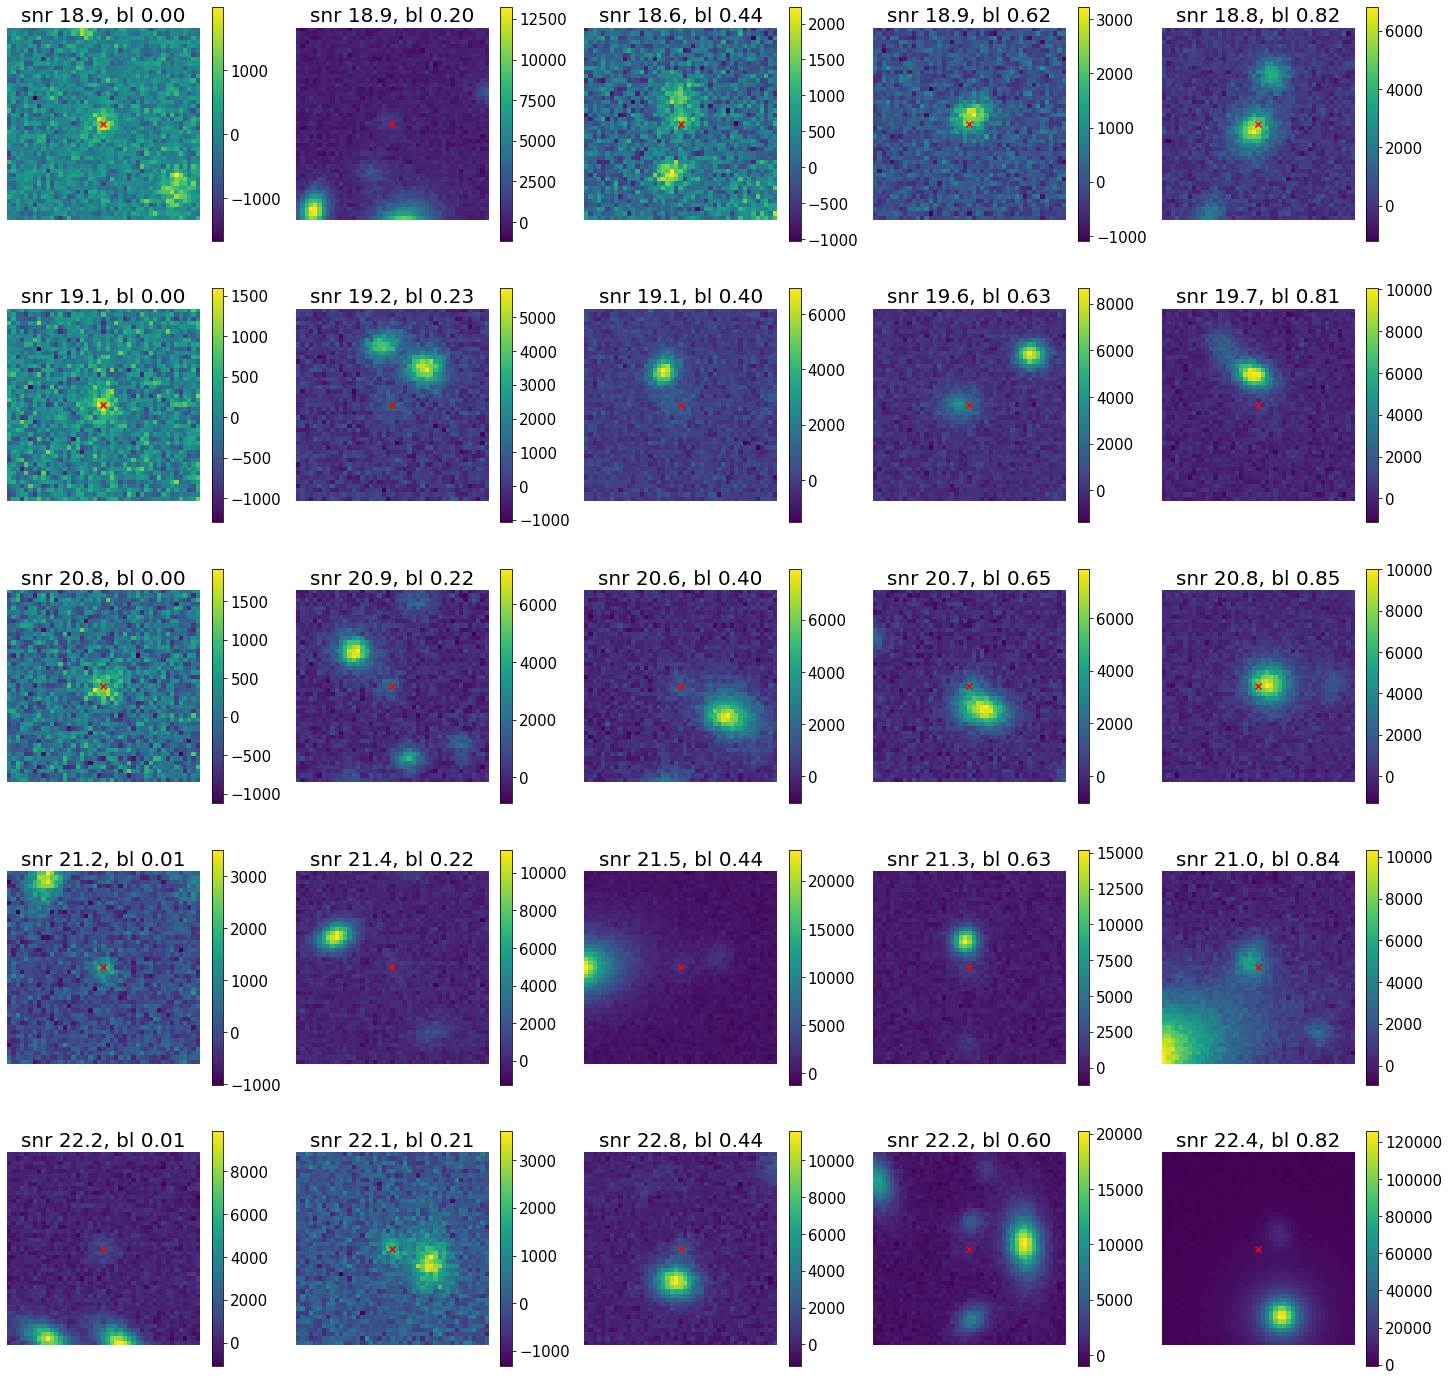

In [ ]:
import hickle
from maddeb.extraction import extract_cutouts

fig, ax = plt.subplots(5, 5, figsize=(5*5,5*5))
for snr_num, snr in enumerate(range(18, 23)):
    # print(snr)
    mask = (madness_results['r_band_snr']>snr) & (madness_results['r_band_snr']<(snr+1))
    snr_cut = madness_results[mask]
    for blendedness_num, blendedness in enumerate(np.arange(0, 1, .2)):
        # print(blendedness)
        mask2 = (snr_cut['r_blendedness']>blendedness) & (snr_cut['r_blendedness']<(blendedness+.05))
        blendedness_cut = snr_cut[mask2]
        
        row = blendedness_cut.sample(random_state=13)
        
        file_num = row['file_num'].values[0]
        field_num = row['field_num'].values[0]
        galaxy_num = row['galaxy_num'].values[0]
        
        # print(row['file_num'].values[0])
        blend = hickle.load(
                os.path.join(
                        simulation_path,
                        str(file_num) + ".hkl",
                    )
                )
        
        x_pos = blend["blend_list"][field_num]["y_peak"][galaxy_num]
        y_pos = blend["blend_list"][field_num]["x_peak"][galaxy_num]
        
        gal_blended = extract_cutouts(
                        blend["blend_images"][field_num],
                        [(x_pos, y_pos)],
                        distances_to_center=False,
                        channel_last=False,
                        cutout_size=45,
                    )[0][0]
        
        
        # print(np.shape(gal_blended))
        
        im1 = ax[snr_num, blendedness_num].imshow(gal_blended[:, :, 2])
        cbar = fig.colorbar(im1, ax=ax[snr_num, blendedness_num])
        cbar.ax.tick_params(labelsize=15)
        ax[snr_num, blendedness_num].set_title("snr {:.1f}, bl {:.2f}".format(row['r_band_snr'].values[0], row['r_blendedness'].values[0]), fontsize=20)
        ax[snr_num, blendedness_num].scatter(22, 22, c="r", marker="x")
        ax[snr_num, blendedness_num].axis('off')
        #print(blendedness_cut)